# DeepShip数据集评估

In [2]:
import os
import glob
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import librosa
except ImportError:
    librosa = None
    print("[Warn] 未找到 librosa，将使用简易 STFT 实现。建议：pip install librosa")

In [3]:
def load_audio_mono(path: str, target_sr: int | None = None):
    """读取音频并转为单通道 float32，必要时重采样到 target_sr。"""
    wav, sr = sf.read(path)
    wav = np.asarray(wav)

    # 多通道转单通道
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)

    # 整数 PCM -> [-1, 1]
    if np.issubdtype(wav.dtype, np.integer):
        info = np.iinfo(wav.dtype)
        wav = wav.astype(np.float32) / max(abs(info.min), info.max)
    else:
        wav = wav.astype(np.float32)

    # 重采样
    if target_sr is not None and sr != target_sr:
        if librosa is None:
            raise RuntimeError("需要 librosa 才能重采样，请先安装 librosa。")
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    return wav, sr


def rms_db(x: np.ndarray) -> float:
    """计算单条音频的 RMS (dB)。"""
    x = np.asarray(x, dtype=np.float32)
    if x.ndim > 1:
        x = np.mean(x, axis=1)
    rms = np.sqrt(np.mean(x ** 2) + 1e-12)
    return 20.0 * np.log10(rms + 1e-12)


def spectral_flatness_frames(
    x: np.ndarray,
    sr: int,
    n_fft: int = 1024,
    hop_length: int = 512,
) -> np.ndarray:
    """
    每一帧的谱平坦度（0~1），越大越像噪声。
    返回 shape: (num_frames,)
    """
    x = np.asarray(x, dtype=np.float32)
    if x.ndim > 1:
        x = np.mean(x, axis=1)

    if librosa is not None:
        S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length)) ** 2
        flatness = librosa.feature.spectral_flatness(S=S)[0]
        return flatness

    # 无 librosa 时的简单实现
    frame_num = 1 + (len(x) - n_fft) // hop_length if len(x) >= n_fft else 1
    if frame_num <= 0:
        frame_num = 1

    window = np.hanning(n_fft).astype(np.float32)
    frames = []
    for i in range(frame_num):
        start = i * hop_length
        end = start + n_fft
        if end > len(x):
            pad = end - len(x)
            frame = np.pad(x[start:], (0, pad), mode="constant")
        else:
            frame = x[start:end]
        frames.append(frame * window)

    frames = np.stack(frames, axis=1)  # (n_fft, frames)
    spec = np.fft.rfft(frames, axis=0)
    power = np.abs(spec) ** 2 + 1e-12

    log_power = np.log(power)
    gmean = np.exp(np.mean(log_power, axis=0))
    amean = np.mean(power, axis=0)
    flatness = gmean / (amean + 1e-12)
    return flatness

In [4]:
def collect_metrics_from_dir(
    root_dir: str,
    exts=(".wav", ".flac"),
    target_sr: int | None = None,
    max_files: int | None = None,
):
    """
    从根目录递归收集音频，计算每条：
      - RMS(dB)
      - 平均谱平坦度
      - 噪声型帧比例 (flatness > 0.5)
    """
    all_paths = []
    for ext in exts:
        all_paths.extend(
            glob.glob(os.path.join(root_dir, "**", f"*{ext}"), recursive=True)
        )

    if not all_paths:
        raise RuntimeError(f"在 {root_dir} 下未找到音频文件，请检查路径或后缀。")

    all_paths = sorted(all_paths)
    if max_files is not None and len(all_paths) > max_files:
        print(f"[Info] 共找到 {len(all_paths)} 条音频，随机抽样 {max_files} 条分析。")
        rng = np.random.default_rng(42)
        all_paths = list(rng.choice(all_paths, size=max_files, replace=False))

    rms_list = []
    flat_mean_list = []
    noise_like_ratio_list = []

    for i, p in enumerate(all_paths, 1):
        try:
            x, sr = load_audio_mono(p, target_sr=target_sr)
        except Exception as e:
            print(f"[Warn] 读取失败，跳过: {p} ({e})")
            continue

        r = rms_db(x)
        rms_list.append(r)

        flat = spectral_flatness_frames(x, sr)
        flat_mean = float(np.mean(flat))
        noise_like_ratio = float(np.mean(flat > 0.5))

        flat_mean_list.append(flat_mean)
        noise_like_ratio_list.append(noise_like_ratio)

        if i % 100 == 0:
            print(f"[Info] 已处理 {i}/{len(all_paths)} 条音频...")

    rms_arr = np.array(rms_list, dtype=np.float32)
    flat_mean_arr = np.array(flat_mean_list, dtype=np.float32)
    noise_like_ratio_arr = np.array(noise_like_ratio_list, dtype=np.float32)

    return rms_arr, flat_mean_arr, noise_like_ratio_arr


def summarize_and_decide(
    rms_arr: np.ndarray,
    flat_mean_arr: np.ndarray,
    noise_like_ratio_arr: np.ndarray,
    title: str = "DeepShip",
):
    """输出统计信息 + 简单启发式判断是否建议去噪。"""
    def stats(x):
        return {
            "mean": float(np.mean(x)),
            "std": float(np.std(x)),
            "p10": float(np.percentile(x, 10)),
            "p25": float(np.percentile(x, 25)),
            "median": float(np.median(x)),
            "p75": float(np.percentile(x, 75)),
            "p90": float(np.percentile(x, 90)),
        }

    rms_s = stats(rms_arr)
    flat_s = stats(flat_mean_arr)
    noise_s = stats(noise_like_ratio_arr)

    print(f"\n===== {title} - RMS(dB) =====")
    for k, v in rms_s.items():
        print(f"{k:>6}: {v:7.2f} dB")

    print(f"\n===== {title} - 平均谱平坦度 (0~1, 越大越噪声) =====")
    for k, v in flat_s.items():
        print(f"{k:>6}: {v:7.3f}")

    print(f"\n===== {title} - 噪声型帧比例 (flatness > 0.5) =====")
    for k, v in noise_s.items():
        print(f"{k:>6}: {v:7.3f}")

    mean_noise_ratio = noise_s["mean"]
    rms_p10 = rms_s["p10"]

    print("\n===== 去噪建议（启发式） =====")
    if mean_noise_ratio > 0.6 and rms_p10 < -35:
        print(">>> 数据整体能量偏低 + 噪声型帧占比很高，建议：")
        print("    - 至少做带通滤波 / 轻度去噪；")
        print("    - 或者先筛掉最弱的 5%~10% 片段，再视情况做降噪。")
    elif mean_noise_ratio > 0.4 and rms_p10 < -30:
        print(">>> 数据中等偏噪，存在不少弱目标片段，建议：")
        print("    - 做 per-segment RMS 归一化；")
        print("    - 结合后续实验，再决定是否需要频域去噪。")
    else:
        print(">>> 从整体统计看，不属于极端噪声占主导的情况。")
        print("    - 可以先只做 RMS 归一化 + 样本筛选，")
        print("    - 去噪可作为可选增强手段，而非硬性必需。")

    # 可视化：RMS & 噪声型帧比例
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(rms_arr, bins=60)
    plt.xlabel("RMS (dB)")
    plt.ylabel("Count")
    plt.title(f"{title} - RMS(dB) Histogram")
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(noise_like_ratio_arr, bins=60)
    plt.xlabel("Noise-like Frame Ratio")
    plt.ylabel("Count")
    plt.title(f"{title} - Noise-like Frame Ratio Histogram")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def evaluate_denoising_need(
    root_dir: str,
    title: str = "DeepShip",
    target_sr: int | None = 32000,
    max_files: int | None = None,
):
    """Jupyter 入口：传路径进来即可。"""
    print(f"[Info] 开始评估数据集（是否需要去噪）: {root_dir}")
    rms_arr, flat_mean_arr, noise_like_ratio_arr = collect_metrics_from_dir(
        root_dir=root_dir,
        target_sr=target_sr,
        max_files=max_files,
    )
    summarize_and_decide(rms_arr, flat_mean_arr, noise_like_ratio_arr, title=title)

[Info] 开始评估数据集（是否需要去噪）: X:\数据集\DeepShip\data_original
[Info] 已处理 100/609 条音频...
[Info] 已处理 200/609 条音频...
[Info] 已处理 300/609 条音频...
[Info] 已处理 400/609 条音频...
[Info] 已处理 500/609 条音频...
[Info] 已处理 600/609 条音频...

===== DeepShip - RMS(dB) =====
  mean:  -30.22 dB
   std:    0.92 dB
   p10:  -30.76 dB
   p25:  -30.60 dB
median:  -30.43 dB
   p75:  -30.19 dB
   p90:  -29.63 dB

===== DeepShip - 平均谱平坦度 (0~1, 越大越噪声) =====
  mean:   0.000
   std:   0.000
   p10:   0.000
   p25:   0.000
median:   0.000
   p75:   0.000
   p90:   0.000

===== DeepShip - 噪声型帧比例 (flatness > 0.5) =====
  mean:   0.000
   std:   0.000
   p10:   0.000
   p25:   0.000
median:   0.000
   p75:   0.000
   p90:   0.000

===== 去噪建议（启发式） =====
>>> 从整体统计看，不属于极端噪声占主导的情况。
    - 可以先只做 RMS 归一化 + 样本筛选，
    - 去噪可作为可选增强手段，而非硬性必需。


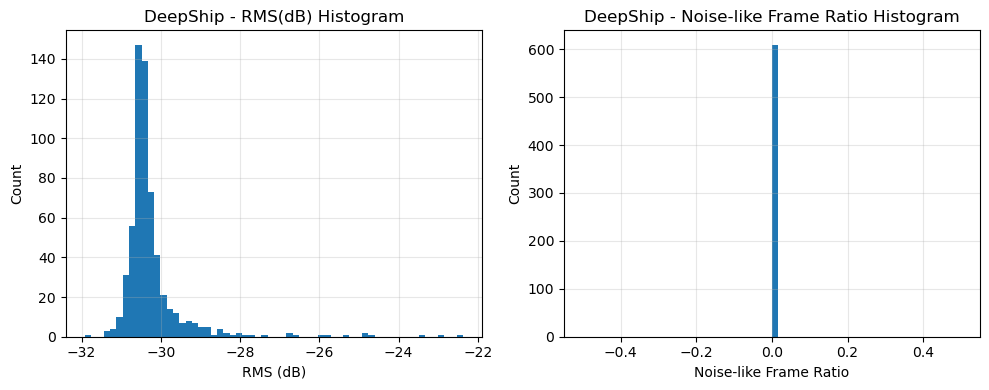

In [9]:
ROOT_DIR = r"X:\数据集\DeepShip\data_original"

evaluate_denoising_need(
    root_dir=ROOT_DIR,
    title="DeepShip",
    target_sr=32000,
    max_files=None,
)

[Info] 开始评估数据集（是否需要去噪）: X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test
[Info] 已处理 100/56864 条音频...
[Info] 已处理 200/56864 条音频...
[Info] 已处理 300/56864 条音频...
[Info] 已处理 400/56864 条音频...
[Info] 已处理 500/56864 条音频...
[Info] 已处理 600/56864 条音频...
[Info] 已处理 700/56864 条音频...
[Info] 已处理 800/56864 条音频...
[Info] 已处理 900/56864 条音频...
[Info] 已处理 1000/56864 条音频...
[Info] 已处理 1100/56864 条音频...
[Info] 已处理 1200/56864 条音频...
[Info] 已处理 1300/56864 条音频...
[Info] 已处理 1400/56864 条音频...
[Info] 已处理 1500/56864 条音频...
[Info] 已处理 1600/56864 条音频...
[Info] 已处理 1700/56864 条音频...
[Info] 已处理 1800/56864 条音频...
[Info] 已处理 1900/56864 条音频...
[Info] 已处理 2000/56864 条音频...
[Info] 已处理 2100/56864 条音频...
[Info] 已处理 2200/56864 条音频...
[Info] 已处理 2300/56864 条音频...
[Info] 已处理 2400/56864 条音频...
[Info] 已处理 2500/56864 条音频...
[Info] 已处理 2600/56864 条音频...
[Info] 已处理 2700/56864 条音频...
[Info] 已处理 2800/56864 条音频...
[Info] 已处理 2900/56864 条音频...
[Info] 已处理 3000/56864 条音频...
[Info] 已处理 3100/56

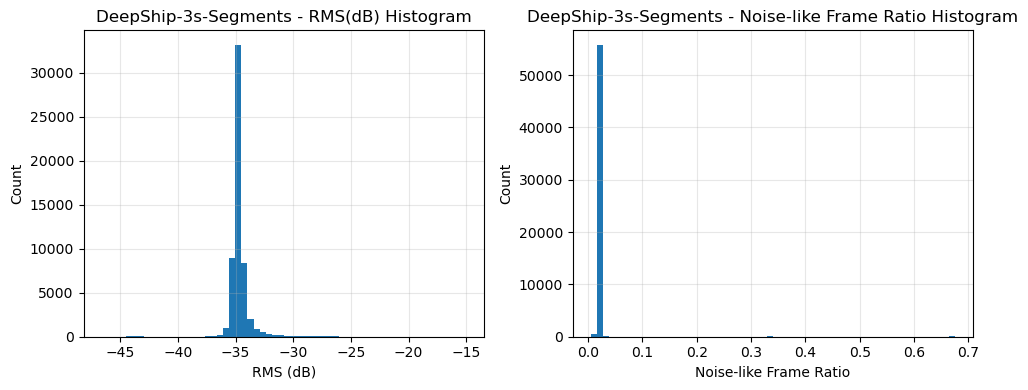

In [10]:
ROOT_DIR_3S = r"X:\数据集\DeepShip\data_preprocessing\data_audio_rename_frame_and_window_3s_0%_16kHz_train_val_test"

evaluate_denoising_need(
    root_dir=ROOT_DIR_3S,
    title="DeepShip-3s-Segments",
    target_sr=32000,
    max_files=None,
)

In [13]:
def plot_full_waveform(file_path: str, target_sr: int):
    wav, sr = load_audio_mono(file_path, target_sr=target_sr)
    time_axis = np.arange(len(wav)) / sr

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, wav, linewidth=0.8)
    plt.title(f"Waveform – {Path(file_path).name}  ({sr/1000:.1f} kHz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    plt.tight_layout

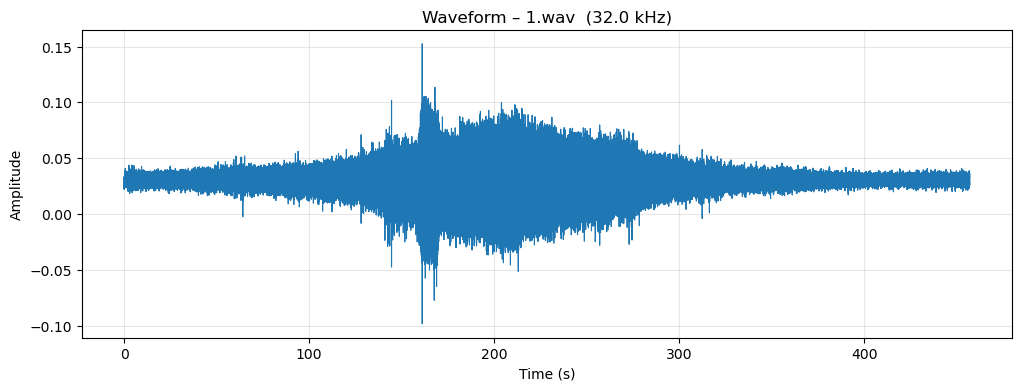

In [14]:
plot_full_waveform(
    r"X:\数据集\DeepShip\data_original\Cargo\20171104-1\1.wav",
    target_sr=None,
)

# ShipEar数据集评估

[Info] 开始评估数据集（是否需要去噪）: X:\数据集\ShipEar\shipsEar_AUDIOS

===== ShipsEar - RMS(dB) =====
  mean:  -33.54 dB
   std:   11.17 dB
   p10:  -45.91 dB
   p25:  -41.34 dB
median:  -32.48 dB
   p75:  -25.03 dB
   p90:  -20.21 dB

===== ShipsEar - 平均谱平坦度 (0~1, 越大越噪声) =====
  mean:   0.002
   std:   0.005
   p10:   0.000
   p25:   0.000
median:   0.000
   p75:   0.001
   p90:   0.003

===== ShipsEar - 噪声型帧比例 (flatness > 0.5) =====
  mean:   0.000
   std:   0.000
   p10:   0.000
   p25:   0.000
median:   0.000
   p75:   0.000
   p90:   0.000

===== 去噪建议（启发式） =====
>>> 从整体统计看，不属于极端噪声占主导的情况。
    - 可以先只做 RMS 归一化 + 样本筛选，
    - 去噪可作为可选增强手段，而非硬性必需。


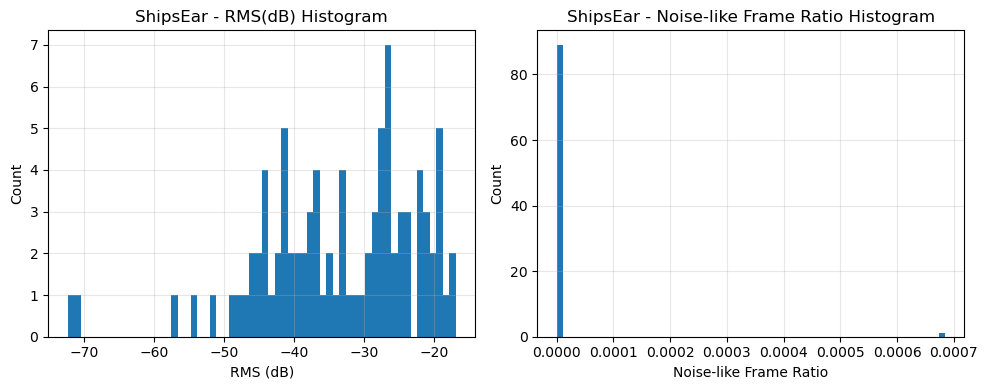

In [7]:
# 1. 指定 ShipsEar 所在目录
ROOT_DIR_SHIPEAR = r"X:\数据集\ShipEar\shipsEar_AUDIOS"

# 2. 调用之前定义好的评估函数
evaluate_denoising_need(
    root_dir=ROOT_DIR_SHIPEAR,
    title="ShipsEar",
    target_sr=None,
    max_files=None,
)
